In [1]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch

import gc

import sys
from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d, griddata

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [2]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 

dtime_sim_start = datetime.datetime(2011,5,20)

t_step_minutes = 5 # minutes


plot_start_delta  = 4  # hours before storm onset to start making plots. set to -1 to run the whole time
plot_end_delta    = -1  # hours after storm onset to end plots. Set to -1 to run for the whole time

sami_data_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/"

lon_keos = [-90,2,90,-178]

global_lat_lim = 75 # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

OVERWRITE = True # be careful!

# num_pool_workers = int(0.75 * os.cpu_count()) # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means. 
num_pool_workers = 6

sample_rate_min = 5 # SHOULD be the same as t_step_minutes above. If not, something will be wrong. Won't throw errors. Gotta pay attention.
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru

out_grid_lats = 75 #num GEOGRAPHIC latitudes to output
out_grid_lons = 60 #num GROGRAPHIC longitudes to output

num_out_grid_alts = 50 #add one to what you want because of inclusive limits. Or make one of your lims (max - min)/steps off from what you want, since it's inclusive. 
out_alt_min = 220
out_alt_max = 1200
spacing = 'linear'



In [3]:
# cols = ['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

# above is all cols (that I care about), below is just edens.

cols = ['edens']

Available columns (for now) are:

['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

In [ ]:
data_out_path = '/home/axb170054/scratch/pickles/SimStormPaper/simstorm_sami_grid_files/'

## Constants:

In [4]:
geo_grid_files = {'glat':'glatu.dat','glon':'glonu.dat','alt':'zaltu.dat', 
                  'mlat':'blatu.dat','mlon':'blonu.dat','malt':'baltu.dat'}


data_files = {'edens':'deneu.dat', 'hplusdens':'deni1u.dat','oplusdens':'deni2u.dat',
              'noplusdens':'deni3u.dat', 'o2plusdens':'deni4u.dat',
              'heplusdens':'deni5u.dat', 'n2plusdens':'deni6u.dat', 
              'nplusdens':'deni7u.dat','hdens':'denn1u.dat','odens':'denn2u.dat', 
              'nodens':'denn3u.dat', 'o2dens':'denn4u.dat', 'hedens':'denn5u.dat', 
              'n2dens':'denn6u.dat', 'ndens':'denn7u.dat'}

time_file = 'time.dat'

## Define Functions

In [5]:
def get_grid_elems_from_parammod(data_dir):
    """
    Will look for: words = ['nz0','nf','nl'] in SAMI files.
    
    inputs:
    ------
    sami path
    
    outputs:
    -------
    nz,nf,nlt,nt :
    - nz  = num points along field line
    - nf  = num field lines along each mag lon
    - nlt = num mag lons
    - nt  = num times
    
    """
    
    #Make sure that we only grab the first instance of each var in the file. 
        # SOmetimes they repeat and we don't want them
    returns = [False, False, [False, False], False]
    
    with open(data_dir  + 'parameter_mod.f90', 'r') as fp:
    # read all lines in a list
        lines = fp.readlines()
        for line in lines:
            # check if string present on a current line
            
            if not returns[0]:
                if line.find('nz0') != -1:
                    nz0 = []
                    for l in line:
                        if l.isdigit():
                            nz0.append(l)
                    if len(nz0[1:4]) == 3:
                        nz = int(''.join(nz0[1:4]))
                        returns[0] = True
            
            if not returns[1]:
                if line.find('nf') != -1:
                    nf = []
                    for l in line:
                        if l.isdigit():
                            nf.append(l)
                    nf = int(''.join(nf))
                    returns[1] = True
                    
            if not returns[2][0]:
                if line.find('nl ') != -1:
                    nl = []
                    for l in line:
                        if l.isdigit():
                            nl.append(l)
                    nl = int(''.join(nl))
                    returns[2][0] = True
                    
            if not returns[2][1]:
                if line.find('numwork ') != -1:
                    numwork = []
                    for l in line:
                        if l.isdigit():
                            numwork.append(l)
                    numwork = int(''.join(numwork))
                    returns[2][1] = True
                    
    #time
    with open(data_dir  + 'time.dat', 'r') as fp:
        lines = fp.readlines()
        nt = len(lines) - 1
            
    return nz, nf, numwork*(nl - 2), nt



In [6]:
def make_times(t0, nt, plot_start_delta = None, plot_end_delta = None):
    times = []
    hrs_since_storm_start = []
    
    for t in range(nt):
        time_here = pd.Timestamp(dtime_sim_start) + t * pd.Timedelta(5, 'minutes')
        times.append(time_here.to_pydatetime())
        hrs = (time_here - dtime_storm_start)/pd.Timedelta(1, 'hour')
        hrs_since_storm_start.append(hrs)
        
        
        
    times_df = pd.read_fwf(os.path.join(sami_data_path, 'time.dat'), 
                            names = ['istep', 'hour', 'minute', 'second', 'hrdelta'], infer_nrows=115)
    times_df.pop('istep');

    times_list = []
    for hr in times_df['hrdelta']:
        times_list.append(dtime_sim_start + datetime.timedelta(hours = hr))    
    
    truths = np.array([pd.Timestamp(times_list[t]).round('T') == times[t] for t in range(len(times))])
    if truths.sum() != len(truths):
        raise ValueError('The times are wrong! Somehow this needs to be fixed. probably outputting fake files again. Take a look and debug before proceeding.')
        
    #maybe chop the time lists, depending on if the plot start/end are given.
    # adjusted to allow for -1 in plot start/end deltas (plot all times)
        
    if plot_start_delta and plot_end_delta:
        if plot_start_delta != -1:
            start_idx = np.argmin(np.abs(np.array(times) 
                                     - (dtime_storm_start - pd.Timedelta(plot_start_delta, 'hour'))))
        else:
            start_idx = 0
            
        if plot_end_delta != -1:
            end_idx = plot_end_delta
        elif plot_end_delta == -1:
            end_idx = len(times)
        else:
            end_idx = len(times)
        
        times = times[start_idx:end_idx]
        hrs_since_storm_start = hrs_since_storm_start[start_idx:end_idx]
        times_list = times_list[start_idx:end_idx]
        
        return times, hrs_since_storm_start, times_list, (start_idx, end_idx)
        
    elif plot_start_delta != plot_end_delta:
        raise ValueError('You cannot specify one and not the other!')
    
    return times, hrs_since_storm_start, times_list

In [7]:
def UT_from_Storm_onset(itime):
    """input a datetime
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = '-' + str(np.abs(int(hrs))).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

In [8]:
def get_sami_grid(sami_data_path = sami_data_path, geo_grid_files = geo_grid_files):

    grid = {}

    for f in geo_grid_files:
        file = open(os.path.join(sami_data_path, geo_grid_files[f]), 'rb')
        raw = np.fromfile(file, dtype='float32')[1:-1].copy()
        file.close()

        grid[f] = raw.reshape(nlt,nf,nz).copy()
    return grid

In [9]:
def read_sami_data(cols, nts):
    """
    Read in sami data for the specified columns and return sama data dict
    
    inputs:
    -------
    cols: list-like
        - Columns you want data for. Does not have to be everything
    
    nts: int OR tuple/list
        - either nt (number of times) if you want all sami data from simulation or:
        - nts (start_time, end_time) if you want plots from a select time period.
    
    """
    sami_data = {}
    
    #handle cut time list and full time list
    if type(nts) != int:
        t_start = nts[0]
        t_end   = nts[1]
        ntimes = t_end - t_start
    else:
        t_start = 0
        t_end = nt
        ntimes = nt
        
    pbar = tqdm(total = len(cols) * ntimes)

    for f in cols:

        sami_data[f] = np.zeros((nlt,nf,nz,ntimes))

        file = open(os.path.join(sami_data_path, data_files[f]), 'rb')
        for t in range(t_end):
            raw = np.fromfile(file, dtype='float32', count = (nz*nf*nlt)+2)[1:-1]
            if t >= t_start:
                sami_data[f][:,:,:,t-t_start] = raw.reshape(nlt,nf,nz).copy()
                pbar.update(1)
        file.close()
    pbar.close()
        
    return sami_data

In [10]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

def make_fits(data):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]

    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    
    ## This is weird. not sure how it still works.
    if type(data) == dict:
        sos = make_filter()
        filtered_arr = {}
        for col in cols:
            filtered_arr[col] = signal.sosfiltfilt(sos, data[col], axis=3)
        return filtered_arr
    else:
        sos = make_filter()
        filtered_arr = signal.sosfiltfilt(sos, data, axis=0)
        return filtered_arr

In [11]:
def remove_outliers(array):
    arr2 = array.copy()
    mean, std, median = np.mean(arr2), np.std(arr2), np.median(arr2) # calculate mean, standard deviation, and median over all elements
    outlier_threshold = 5 # set outlier threshold (in terms of number of standard deviations)
    outliers = np.logical_or(arr2 < mean - outlier_threshold * std, arr2 > mean + outlier_threshold * std) # find outliers
    arr2[outliers] = median # set outliers to median
    return arr2

In [12]:
def geo_to_cart(lats_, lons_, alts_, ntime):
    """
    get cartesian from a grid slice
    """
    
    coord_arr = []
    
    if type(alts_) != list:
        if type(alts_) != np.array:
            if type(alts_) != np.ndarray:
                alts_ = [ alts_ ]


    for lat in lats_:
        for lon in lons_:
            for alt in alts_:
                coord_arr.append([(alt + 6371)/6371, lat, lon])
                
    dtime = times[ntime]

    coords = Coords(coord_arr, 'GEO','sph')
    coords.ticks = Ticktock([dtime for k in range(len(coord_arr))])

    newcoords = coords.convert('GEO','car')
    
    return newcoords

In [13]:
def grid_to_cartesian(grid, ntime):

    coords0 = list(zip(grid['malt'].flatten()/ 6371 , grid['mlat'].flatten(), grid['mlon'].flatten()))
    dtime = times[ntime]

    coords = Coords(coords0, 'CDMAG','sph')
    coords.ticks = Ticktock([dtime for k in range(len(coords0))])

    newcoords = coords.convert('GEO','car')
    
    return newcoords

## Read in data

In [14]:
nz, nf, nlt, nt = get_grid_elems_from_parammod(sami_data_path)

In [15]:
times, hrs, times_list, nts = make_times(dtime_sim_start, nt, plot_start_delta, plot_end_delta)
new_nt = np.diff(nts)[0]

In [16]:
## OR.... to run for all times:
# times, hrs, times_list = make_times(dtime_sim_start, nt)


In [17]:
print(nlt, nf, nz, nts, new_nt)
nt = new_nt

80 72 256 (404, 615) 211


In [18]:
grid = get_sami_grid()

In [19]:
for g in grid.keys():
    print(g, grid[g].shape)
    

glat (80, 72, 256)
glon (80, 72, 256)
alt (80, 72, 256)
mlat (80, 72, 256)
mlon (80, 72, 256)
malt (80, 72, 256)


In [20]:
# sami grid
sami_data = read_sami_data(cols, nts)
# or
# sami_data = read_sami_data(cols, nt)

print('sami data shape: ', sami_data[cols[0]].shape)

  0%|          | 0/211 [00:00<?, ?it/s]

sami data shape:  (80, 72, 256, 211)


In [21]:
print('Calculating fits. This will take a moment...')
fits_sami = make_fits(sami_data)

Calculating fits. This will take a moment...


## Some setup

In [22]:
mlons = np.unique(grid['mlon'].round(2))

In [23]:
sami_data['edens'].shape

(80, 72, 256, 211)

In [69]:
out_grid_lats = 70
out_grid_lons = 75

In [70]:
# out_alts = np.linspace(out_alt_min, out_alt_max, num_out_grid_alts)
out_lats = np.linspace(-global_lat_lim,global_lat_lim, out_grid_lats)
out_lons = np.linspace(0,360, out_grid_lons +1)[1:]
out_alts = np.array([250,300,350,400,450,500,550,600,700,800,840,880,900,1000])

In [71]:
out_lats, out_lons, out_alts, len(out_lats), len(out_lons), len(out_alts)

(array([-75.        , -72.82608696, -70.65217391, -68.47826087,
        -66.30434783, -64.13043478, -61.95652174, -59.7826087 ,
        -57.60869565, -55.43478261, -53.26086957, -51.08695652,
        -48.91304348, -46.73913043, -44.56521739, -42.39130435,
        -40.2173913 , -38.04347826, -35.86956522, -33.69565217,
        -31.52173913, -29.34782609, -27.17391304, -25.        ,
        -22.82608696, -20.65217391, -18.47826087, -16.30434783,
        -14.13043478, -11.95652174,  -9.7826087 ,  -7.60869565,
         -5.43478261,  -3.26086957,  -1.08695652,   1.08695652,
          3.26086957,   5.43478261,   7.60869565,   9.7826087 ,
         11.95652174,  14.13043478,  16.30434783,  18.47826087,
         20.65217391,  22.82608696,  25.        ,  27.17391304,
         29.34782609,  31.52173913,  33.69565217,  35.86956522,
         38.04347826,  40.2173913 ,  42.39130435,  44.56521739,
         46.73913043,  48.91304348,  51.08695652,  53.26086957,
         55.43478261,  57.60869565,  59.

## I think this is the best way to do it... Need to make sure we can resolve LSTIDS though.

In [72]:
norm_alts = (grid['alt'].flatten() < 1300) & (grid['alt'].flatten() > 200)

In [ ]:
%%time

pbar = tqdm(total = len(times))
preds = np.zeros([len(times),len(out_lats), len(out_lons),  len(out_alts)])



for ntime, dt in enumerate(times):
    
    # print('cart grid')
    grid_cart = grid_to_cartesian(grid, ntime)

    xs = grid_cart.data[:,0][norm_alts]
    ys = grid_cart.data[:,1][norm_alts]
    zs = grid_cart.data[:,2][norm_alts]
    
    # print('zipping')
    
    loc_grid = list(zip(xs, ys, zs))
    
    # print('making output grid')
    
    out_grid = geo_to_cart(out_lats, out_lons, out_alts, ntime)

    out_xs = out_grid.data[:,0]
    out_ys = out_grid.data[:,1]
    out_zs = out_grid.data[:,2]

    datas = sami_data['edens'][:,:,:,ntime].flatten()[norm_alts]
    
    # print('building interpolator')
    
    interp = LinearNDInterpolator(loc_grid , datas, rescale = True)
    # print('interpolating')
    pred = interp(list(zip(out_xs, out_ys, out_zs)))
    
    # break
    
    preds[ntime] = pred.reshape([len(out_lats), len(out_lons), len(out_alts)])
    
    pbar.update(1)

  0%|          | 0/211 [00:00<?, ?it/s]

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [ ]:
np.product([len(out_lats), len(out_lons), len(out_alts)])

In [ ]:
a = 5

In [ ]:
plt.imshow(preds[0,:,:,a], origin = 'lower', extent = [min(out_lons), max(out_lons), min(out_lats), max(out_lats)], aspect = 'auto')

In [ ]:
alt_mask_plot = (np.abs(grid['alt'].flatten() - out_alts[a]) < 10)
plt.scatter(grid['glon'].flatten()[alt_mask_plot], grid['glat'].flatten()[alt_mask_plot], c = sami_data['edens'][:,:,:,ntime].flatten()[alt_mask_plot])
plt.ylim(min(out_lats), max(out_lats))

## THen filter

In [ ]:
sos = make_filter()
filtered = signal.sosfiltfilt(sos, preds, axis = 0)

sanity check first, then save.

## Save everything to files. 

In [54]:
preds.tofile(data_out_path + 'sami_grid_predicted')
out_lats.to_file(data_out_path + 'out_lats')
out_lons.to_file(data_out_path + 'out_lons')
out_alts.to_file(data_out_path + 'out_alts')
filtered.to_file(data_out_path + 'bp_filtered')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

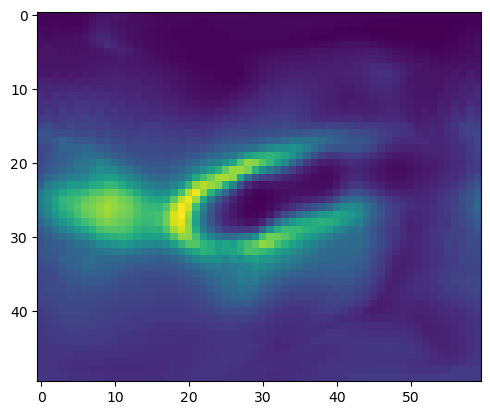

In [68]:
plt.imshow(preds[0,:,:,3])

In [27]:
ntime = 69
mlon = mlons[13]

In [186]:
mlons

array([  2.25,   6.75,  11.25,  15.75,  20.25,  24.75,  29.25,  33.75,
        38.25,  42.75,  47.25,  51.75,  56.25,  60.75,  65.25,  69.75,
        74.25,  78.75,  83.25,  87.75,  92.25,  96.75, 101.25, 105.75,
       110.25, 114.75, 119.25, 123.75, 128.25, 132.75, 137.25, 141.75,
       146.25, 150.75, 155.25, 159.75, 164.25, 168.75, 173.25, 177.75,
       182.25, 186.75, 191.25, 195.75, 200.25, 204.75, 209.25, 213.75,
       218.25, 222.75, 227.25, 231.75, 236.25, 240.75, 245.25, 249.75,
       254.25, 258.75, 263.25, 267.75, 272.25, 276.75, 281.25, 285.75,
       290.25, 294.75, 299.25, 303.75, 308.25, 312.75, 317.25, 321.75,
       326.25, 330.75, 335.25, 339.75, 344.25, 348.75, 353.25, 357.75],
      dtype=float32)

In [181]:
field_line_src = sami_data['edens'][:,:,:,ntime].copy()

In [187]:
plotlim_mask = (np.abs(grid['alt']) < 1200) & (np.abs(grid['alt']) > 200) & (
        np.abs(grid['mlat'])  < 65+2 )
# mask2 = (plotlim_mask) & (np.abs(grid['mlon'] - mlon) < 0.2)

srcdata_mask = (np.abs(grid['alt']) < 1300) & (
        np.abs(grid['mlat'])  < 67+2 )
# mask2_data = (plotlim_mask) & (np.abs(grid['mlon'] - mlon) < 8)


In [197]:
ntime_grid = grid_to_cartesian(grid, ntime)

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [217]:
ntime_grid.data[:,0].shape

(1474560,)

In [218]:
np.product(sami_data['edens'][:,:,:,ntime].shape)

1474560

In [205]:
plot_mask = (grid['alt'] > 375) & (grid['alt'] < 425)

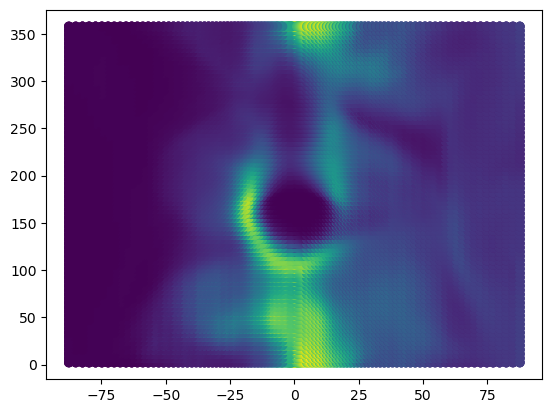

In [206]:
plt.scatter(grid['mlat'][plot_mask], grid['mlon'][plot_mask], c=sami_data['edens'][plot_mask,ntime])

In [244]:
new_grid = []

for lat in out_lats:
    for lon in out_lons:
        new_grid.append([(400 + 6371)/6371, lat, lon])

In [245]:
new_grid = np.array(new_grid)

In [256]:
new_grid.shape

(4560, 3)

In [246]:
carts = geo_to_cart(new_grid, ntime)

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [250]:
tree = build_tree(ntime_grid.data)

In [255]:
for j in range(750,3500,750):
    try:
        preds, dists = make_preds_nearest(ntime_grid.data[:,0], ntime_grid.data[:,1], ntime_grid.data[:,2],
                                  sami_data['edens'][:,:,:,ntime].flatten(), carts.data, j, tree)
    except ValueError:
        pass

 error  at  1515  in idxs, moving to more neighbors from  750 , alt was  1.062784492230419
 error  at  1755  in idxs, moving to more neighbors from  1500 , alt was  1.0627844922304188
 error  at  1815  in idxs, moving to more neighbors from  2250 , alt was  1.062784492230419
 error  at  1932  in idxs, moving to more neighbors from  3000 , alt was  1.062784492230419


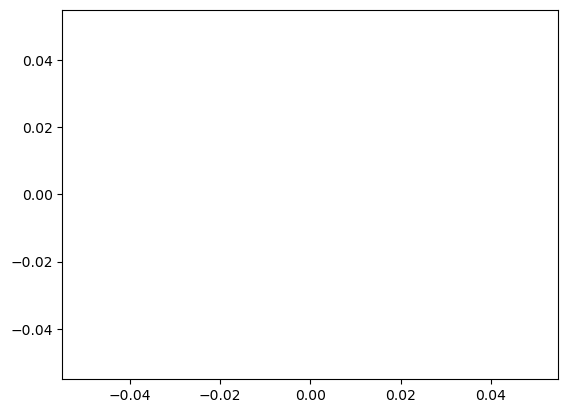

In [260]:
plt.scatter(new_grid[:,1], new_grid[:,2], c=preds)
plt.show()
plt.close()

In [288]:
carts.data.shape

(4560, 3)

(-1.1, 1.1)

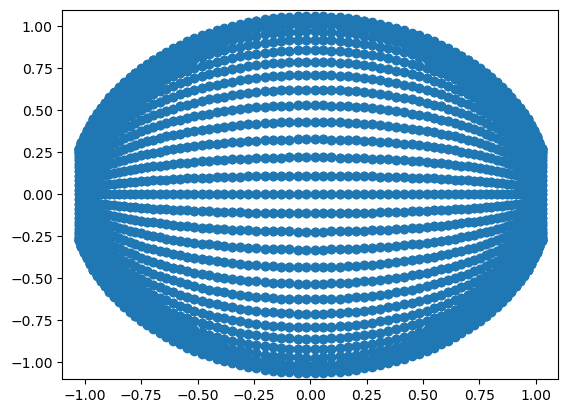

In [299]:
plt.scatter(carts.data[:,2], carts.data[:,1])
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

(-1.1, 1.1)

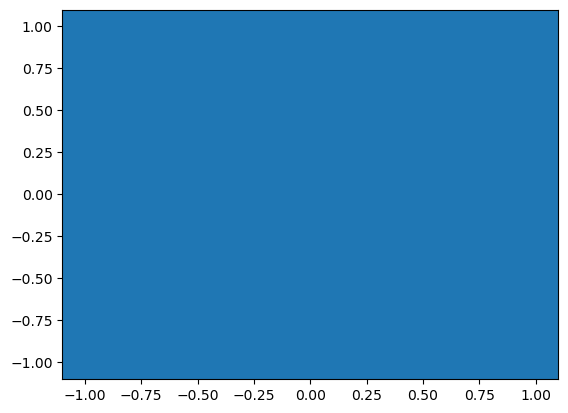

In [300]:
plt.scatter(ntime_grid.data[:,2], ntime_grid.data[:,1])
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

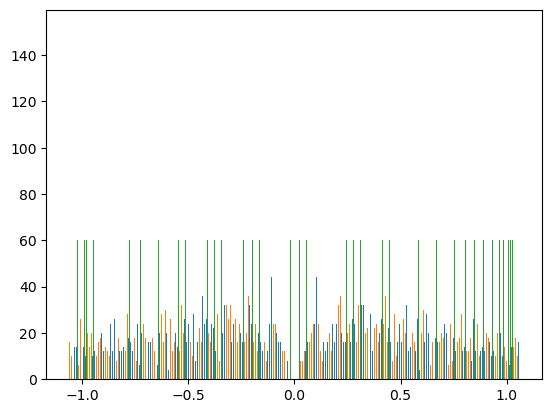

In [247]:
plt.hist(carts.data, bins = 250);

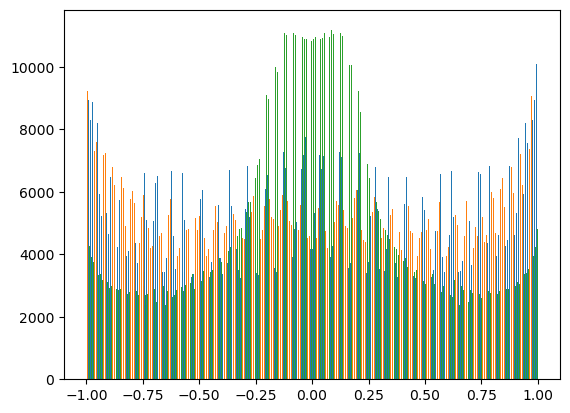

In [249]:
plt.hist(ntime_grid.data, bins = 250, range = (-1,1));

In [308]:
out_lats, out_lons

(array([-75., -73., -71., -69., -67., -65., -63., -61., -59., -57., -55.,
        -53., -51., -49., -47., -45., -43., -41., -39., -37., -35., -33.,
        -31., -29., -27., -25., -23., -21., -19., -17., -15., -13., -11.,
         -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,   7.,   9.,  11.,
         13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,  31.,  33.,
         35.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,  51.,  53.,  55.,
         57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.]),
 array([-174., -168., -162., -156., -150., -144., -138., -132., -126.,
        -120., -114., -108., -102.,  -96.,  -90.,  -84.,  -78.,  -72.,
         -66.,  -60.,  -54.,  -48.,  -42.,  -36.,  -30.,  -24.,  -18.,
         -12.,   -6.,    0.,    6.,   12.,   18.,   24.,   30.,   36.,
          42.,   48.,   54.,   60.,   66.,   72.,   78.,   84.,   90.,
          96.,  102.,  108.,  114.,  120.,  126.,  132.,  138.,  144.,
         150.,  156.,  162.,  168.,  174.,  180.]))

In [494]:
out_grid_lats = 90
out_grid_lons = 90

In [496]:
# out_alts = np.linspace(out_alt_min, out_alt_max, num_out_grid_alts)
out_lats = np.linspace(-global_lat_lim,global_lat_lim, out_grid_lats + 1)
out_lons = np.linspace(0,360, out_grid_lons + 1)[1:]

In [579]:
target_alt = 850

In [580]:
mask = (np.abs(grid['alt'] - target_alt) < .013*target_alt)

In [581]:
out_grid_lats, out_grid_lons

(90, 90)

In [582]:
a_grid = grid['glat'][mask]
o_grid = grid['glon'][mask]

In [583]:
a_r, o_r = np.meshgrid(out_lats, out_lons)

In [584]:
pts = sami_data['edens'][mask,ntime]

In [585]:
interpolated_values = griddata(list(zip(a_grid, o_grid)), pts, list(zip(a_r.flatten(),o_r.flatten())), method='linear')

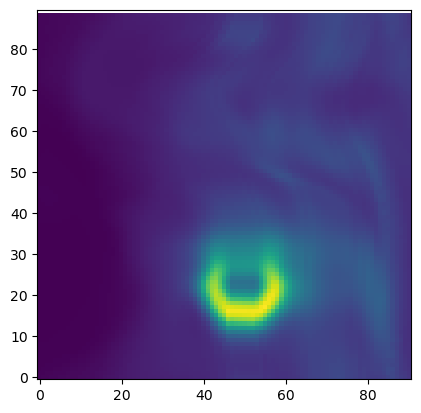

In [586]:
plt.imshow(interpolated_values.reshape(len(out_lons), len(out_lats)), origin = 'lower')

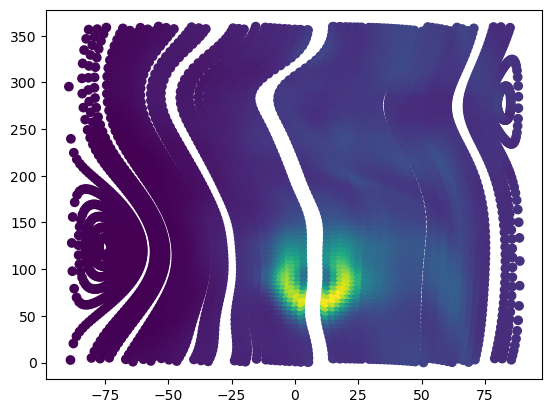

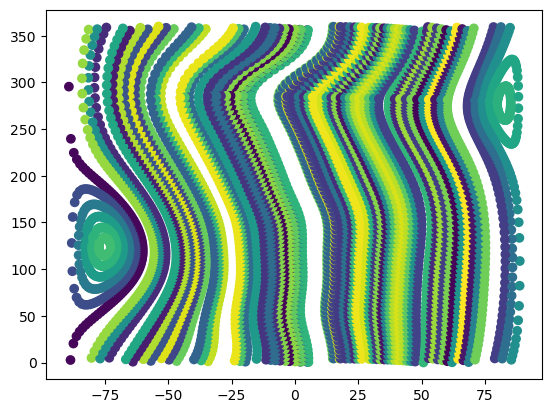

In [590]:
plt.scatter(grid['glat'][mask], grid['glon'][mask], c=sami_data['edens'][mask, ntime])

plt.show()
plt.close()
plt.scatter(grid['glat'][mask], grid['glon'][mask], c=grid['alt'][mask])

In [588]:
mask.sum()

5760

In [593]:
len(out_lats), len(out_lons)

(91, 90)

In [55]:
target_alt = 750

In [56]:
mask = (np.abs(grid['alt'] - target_alt) < .05*target_alt)

In [57]:
a_grid = grid['glat'][mask]
o_grid = grid['glon'][mask]
l_grid = grid['alt'][mask]

In [58]:
a_r, o_r, l_r = np.meshgrid(out_lats, out_lons, target_alt)

# interpolated_values = griddata(list(zip(a_grid, o_grid)), pts, list(zip(a_r.flatten(),o_r.flatten())), method='linear')

In [59]:
new_values = np.zeros([len(times), len(out_lons), len(out_lats)])

for ntime in tqdm(range(len(times))):
    pts = sami_data['edens'][mask,ntime]
    interpolated_values = griddata(list(zip(a_grid, o_grid, l_grid)), pts, list(zip(a_r.flatten(),o_r.flatten(), l_r.flatten())), method='linear')
    new_values[ntime] = interpolated_values.reshape(len(out_lons), len(out_lats))
    
    # break

  0%|          | 0/211 [00:00<?, ?it/s]

In [60]:
new_values.shape

(211, 60, 50)

In [61]:
sos = make_filter()
new_fits = signal.sosfiltfilt(sos, new_values, axis = 0)

In [62]:
new_fits.shape

(211, 60, 50)

In [63]:
diffs = 100*(new_fits - new_values)/new_values

In [66]:
lon = 30

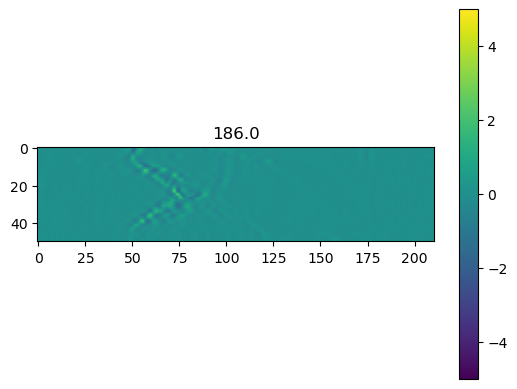

In [67]:
plt.imshow(diffs[:,lon,:].T, vmin = -5, vmax = 5)
plt.colorbar()
plt.title(out_lons[lon]);

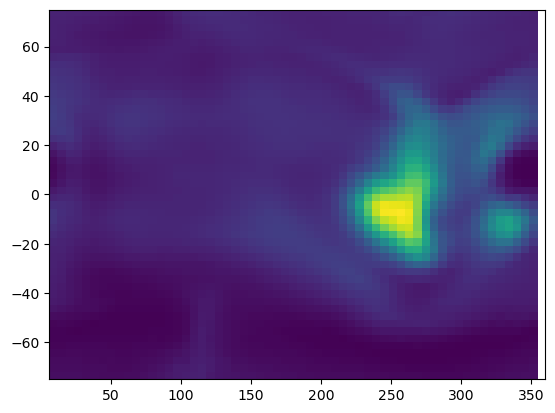

In [74]:
plt.imshow(new_values[ntime].T, origin = 'lower', extent = [min(out_lons), max(out_lons), min(out_lats), max(out_lats)], aspect = 'auto')

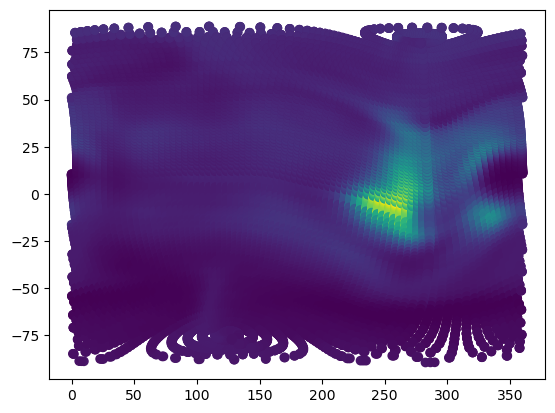

In [73]:
plt.scatter(grid['glon'][mask], grid['glat'][mask], c=sami_data['edens'][mask,ntime])

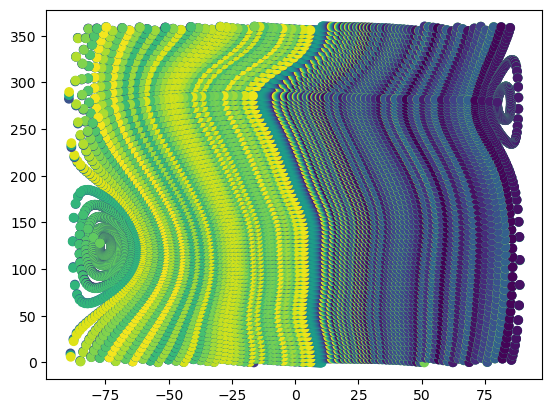

In [68]:
plt.scatter(grid['glat'][mask], grid['glon'][mask], c=grid['alt'][mask])

In [75]:
target_alt = 750

In [76]:
mask = (np.abs(grid['alt'] - target_alt) < .03*target_alt)

In [77]:
a_grid = grid['glat'][mask]
o_grid = grid['glon'][mask]
l_grid = grid['alt'][mask]

In [78]:
a_r, o_r, l_r = np.meshgrid(out_lats, out_lons, target_alt)

# interpolated_values = griddata(list(zip(a_grid, o_grid)), pts, list(zip(a_r.flatten(),o_r.flatten())), method='linear')

In [79]:
new_values2 = np.zeros([len(times), len(out_lons), len(out_lats)])

for ntime in tqdm(range(len(times))):
    pts = sami_data['edens'][mask,ntime]
    interpolated_values = griddata(list(zip(a_grid, o_grid, l_grid)), pts, list(zip(a_r.flatten(),o_r.flatten(), l_r.flatten())), method='linear')
    new_values2[ntime] = interpolated_values.reshape(len(out_lons), len(out_lats))
    
    # break

  0%|          | 0/211 [00:00<?, ?it/s]

In [87]:
sos = make_filter()
new_fits2 = signal.sosfiltfilt(sos, new_values2, axis = 0)

In [88]:
new_fits2.shape

(211, 60, 50)

In [89]:
diffs2 = 100*(new_fits2 - new_values2)/new_values2

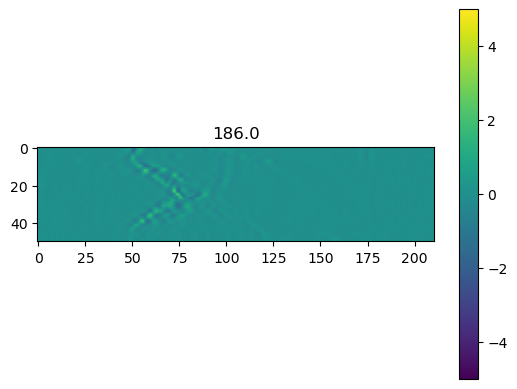

In [90]:
plt.imshow(diffs2[:,30,:].T, vmin = -5, vmax = 5)
plt.colorbar()
plt.title(out_lons[30]);

In [764]:
## This will probably take too long. Let's try binning, then fitting (a spline?) to the bins.

In [27]:
out_lats, out_lons

(array([-75.        , -71.93877551, -68.87755102, -65.81632653,
        -62.75510204, -59.69387755, -56.63265306, -53.57142857,
        -50.51020408, -47.44897959, -44.3877551 , -41.32653061,
        -38.26530612, -35.20408163, -32.14285714, -29.08163265,
        -26.02040816, -22.95918367, -19.89795918, -16.83673469,
        -13.7755102 , -10.71428571,  -7.65306122,  -4.59183673,
         -1.53061224,   1.53061224,   4.59183673,   7.65306122,
         10.71428571,  13.7755102 ,  16.83673469,  19.89795918,
         22.95918367,  26.02040816,  29.08163265,  32.14285714,
         35.20408163,  38.26530612,  41.32653061,  44.3877551 ,
         47.44897959,  50.51020408,  53.57142857,  56.63265306,
         59.69387755,  62.75510204,  65.81632653,  68.87755102,
         71.93877551,  75.        ]),
 array([  6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,  66.,
         72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126., 132.,
        138., 144., 150., 156., 162., 168., 17

In [27]:
out_lats

array([-75.        , -71.93877551, -68.87755102, -65.81632653,
       -62.75510204, -59.69387755, -56.63265306, -53.57142857,
       -50.51020408, -47.44897959, -44.3877551 , -41.32653061,
       -38.26530612, -35.20408163, -32.14285714, -29.08163265,
       -26.02040816, -22.95918367, -19.89795918, -16.83673469,
       -13.7755102 , -10.71428571,  -7.65306122,  -4.59183673,
        -1.53061224,   1.53061224,   4.59183673,   7.65306122,
        10.71428571,  13.7755102 ,  16.83673469,  19.89795918,
        22.95918367,  26.02040816,  29.08163265,  32.14285714,
        35.20408163,  38.26530612,  41.32653061,  44.3877551 ,
        47.44897959,  50.51020408,  53.57142857,  56.63265306,
        59.69387755,  62.75510204,  65.81632653,  68.87755102,
        71.93877551,  75.        ])

In [34]:
pbar = tqdm(total = len(out_lats)*len(out_lons) * len(times))

pred_full = np.zeros([len(times), len(out_lats), len(out_lons), len(out_alts)])

for ntime in range(len(times)):
    for nlat, lat in enumerate(out_lats):
        for nlon, lon in enumerate(out_lons):
            mask = (np.abs(grid['glat'] - lat) < 4) & (np.abs(grid['glon'] - lon) < 6)

            gridalts = grid['alt'][mask]
            gridlats = grid['glat'][mask]
            gridlons = grid['glon'][mask]
            edens = sami_data['edens'][mask,ntime].copy()
            
            interp = LinearNDInterpolator(list(zip(gridlats, gridlons, gridalts)), edens)
            preds = interp(lat,lon,out_alts)
            
            pred_full[ntime, nlat, nlon] = preds
            
            pbar.update(1)

            break
        break
    #break

  0%|          | 0/633000 [00:00<?, ?it/s]

In [35]:
plt.scatter(alt, edens)
plt.scatter(out_alts, preds)
plt.xscale('log')

NameError: name 'alt' is not defined

In [823]:
new_out_alts = np.array([250,300,350,450,550,650,700,800,840,880,900,1000])

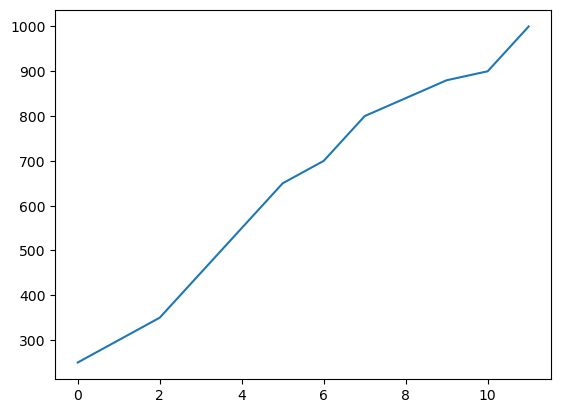

In [838]:
plt.plot(new_out_alts)

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [891]:
len(xs), np.product(sami_data['edens'].shape)/len(times)

(1474560, 1474560.0)

In [52]:

ntime = 69

In [53]:
grid_cart = grid_to_cartesian(grid, ntime)

xs = grid_cart.data[:,0]
ys = grid_cart.data[:,1]
zs = grid_cart.data[:,2]

datas = sami_data['edens'][:,:,:,ntime].flatten()

/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


In [54]:
out_grid = geo_to_cart(out_lats, out_lons, alts, ntime)

out_xs = out_grid.data[:,0]
out_ys = out_grid.data[:,1]
out_zs = out_grid.data[:,2]

NameError: name 'alts' is not defined

In [896]:
interp = LinearNDInterpolator(list(zip(xs,ys,zs)), datas, rescale = True)

In [898]:
preds = interp(list(zip(out_xs, out_ys, out_zs)))

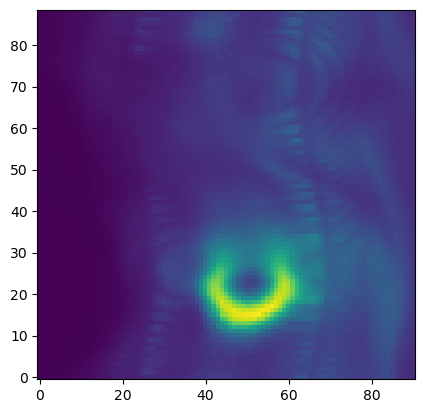

In [907]:
plt.imshow(preds.reshape(len(out_lats), len(out_lons)).T, origin = 'lower')

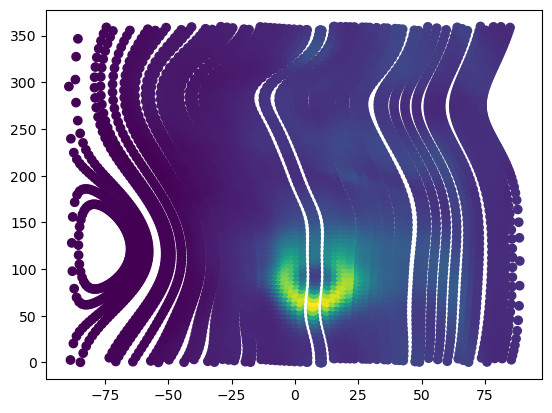

In [905]:
alt_mask_plot = (np.abs(grid['alt'].flatten() - target_alt) < 10)
plt.scatter(grid['glat'].flatten()[alt_mask_plot], grid['glon'].flatten()[alt_mask_plot], c = sami_data['edens'][:,:,:,ntime].flatten()[alt_mask_plot])

In [52]:
len(out_lats), len(out_lons)

(50, 60)

In [53]:

ntime = 69

In [54]:
alt_mask_plot = (np.abs(grid['alt'].flatten() - target_alt) < 10)
alt_mask_terp = (np.abs(grid['alt'].flatten() - target_alt) < 60)

In [56]:
grid_cart = grid_to_cartesian(grid, ntime)

xs = grid_cart.data[:,0][alt_mask_terp]
ys = grid_cart.data[:,1][alt_mask_terp]
zs = grid_cart.data[:,2][alt_mask_terp]

datas = sami_data['edens'][:,:,:,ntime].flatten()[alt_mask_terp]

In [57]:
out_grid = geo_to_cart(out_lats, out_lons, target_alt, ntime)

out_xs = out_grid.data[:,0]
out_ys = out_grid.data[:,1]
out_zs = out_grid.data[:,2]

In [65]:
preds = np.zeros([len(times), len(out_lons), len(out_lats)])

for nt in tqdm(range(len(times))):
    datas = sami_data['edens'][:,:,:,nt].flatten()[alt_mask_terp]
    interp = LinearNDInterpolator(list(zip(xs,ys,zs)), datas, rescale = True)
    pred = interp(list(zip(out_xs, out_ys, out_zs)))
    
    preds[nt] = pred.reshape(len(out_lats), len(out_lons)).T

  0%|          | 0/211 [00:00<?, ?it/s]

In [66]:
preds.shape

(211, 60, 50)

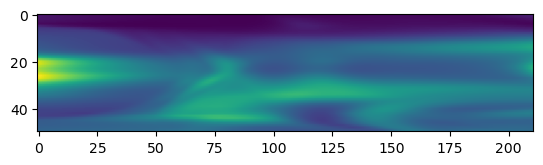

In [67]:
plt.imshow(preds[:,35,:].T)

In [74]:
sos = make_filter()
new_fits2 = signal.sosfiltfilt(sos, preds, axis = 0)

In [75]:
new_fits2.shape

(211, 60, 50)

In [76]:
diffs2 = 100*(new_fits2 - preds)/preds

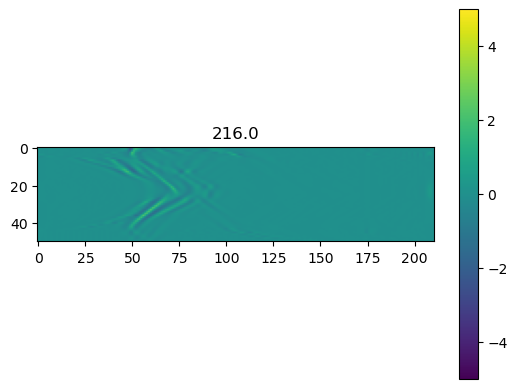

In [77]:
plt.imshow(diffs2[:,35,:].T, vmin = -5, vmax = 5)
plt.colorbar()
plt.title(out_lons[35]);